In [1]:
from scipy.optimize import curve_fit

import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import zoom
import pandas as pd
import trackpy as tp
import pims

import cv2 as cv

import copy

import sklearn
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

import scipy
from scipy import ndimage 
#import needle
import pims

from scipy.interpolate import UnivariateSpline
from scipy.ndimage.filters import uniform_filter1d

from scipy.fft import fft, fftfreq, fftshift, rfft, rfftfreq

Set your directory to the location of the images:

In [2]:
ls

1.3um_10x_scalebarwrong_12_14_2021_fluor_3.ipynb


In [3]:
#v = pims.ImageSequence('Capture*.TIFF',as_grey=True)

In [3]:
filename = '1.3um_10x_scalebarwrong_12_14_2021_fluor_3'

View the first image:

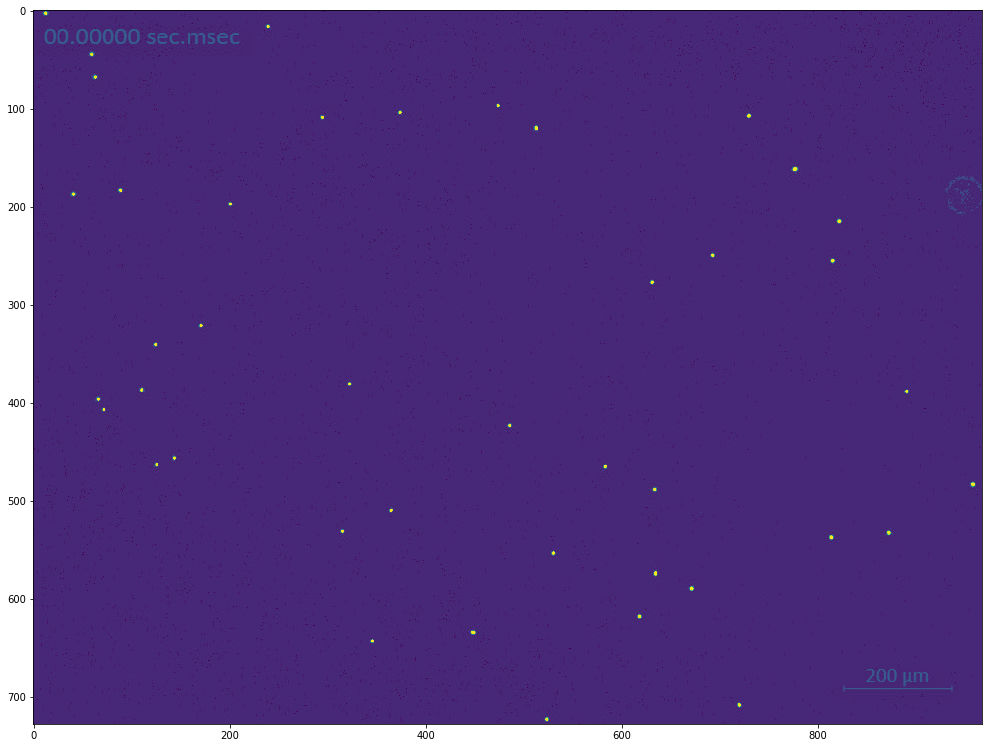

In [4]:
#vid = cv.VideoCapture(filename+'.mp4')
vid = cv.VideoCapture(filename+'.avi')

frame_number = 1
vid.set(1, frame_number-1)
suc,im1 = vid.read()
im1 = cv.cvtColor(im1,cv.COLOR_BGR2GRAY);

fig, ax = plt.subplots(figsize=(17, 17))
plt.imshow(im1)

Find the background image:

In [5]:
suc,im1 = vid.read()#read the first image
im1 = cv.cvtColor(im1,cv.COLOR_BGR2GRAY);
dim=np.shape(im1)

indx, indy = np.meshgrid(range(dim[1]),range(dim[0]))#the indices in matrix form

fps = vid.get(cv.CAP_PROP_FPS)
totalNoFrames = vid.get(cv.CAP_PROP_FRAME_COUNT);
totalNoFrames=int(totalNoFrames)

In [6]:
lastframe=totalNoFrames
img_int = np.zeros([dim[0],dim[1],len(list(range(0,lastframe,20)))])#pre-allocate median image intensity
itera=0;
for i in np.array(list(range(0,lastframe,20))):
    vid.set(1, i-1)
    suc,im1 = vid.read()
    im1 = cv.cvtColor(im1,cv.COLOR_BGR2GRAY);
    img_int[:,:,itera]=im1
    itera = itera+1;
background = np.median(img_int,axis=2)

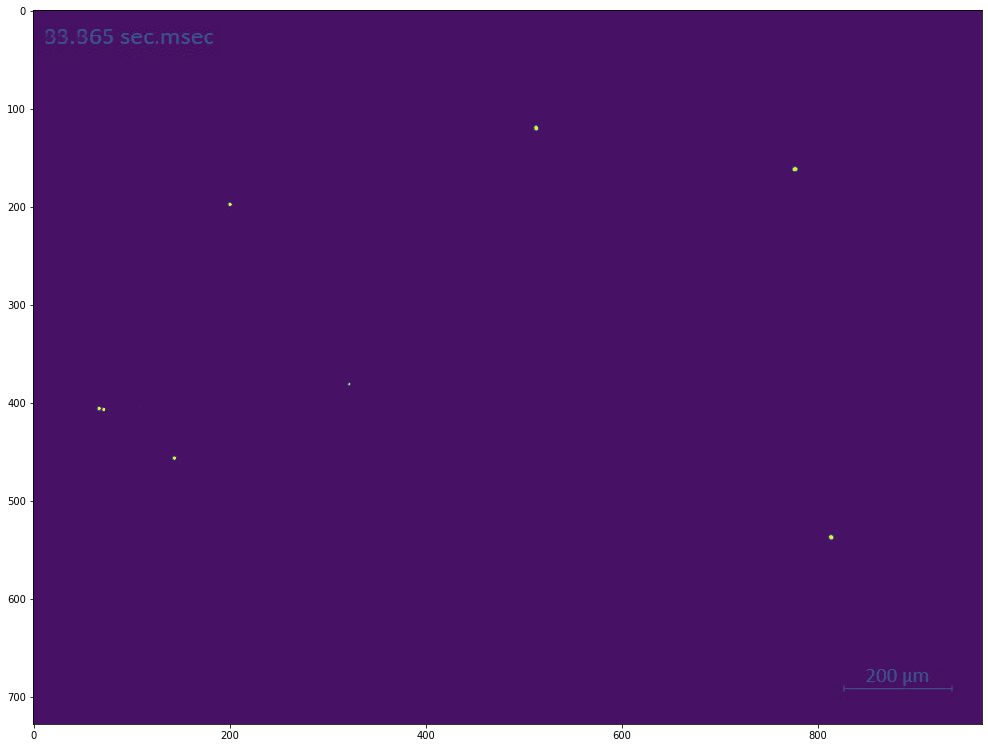

In [7]:
fig, ax = plt.subplots(figsize=(17, 17))
plt.imshow(background)

View the first image with the background subtracted:

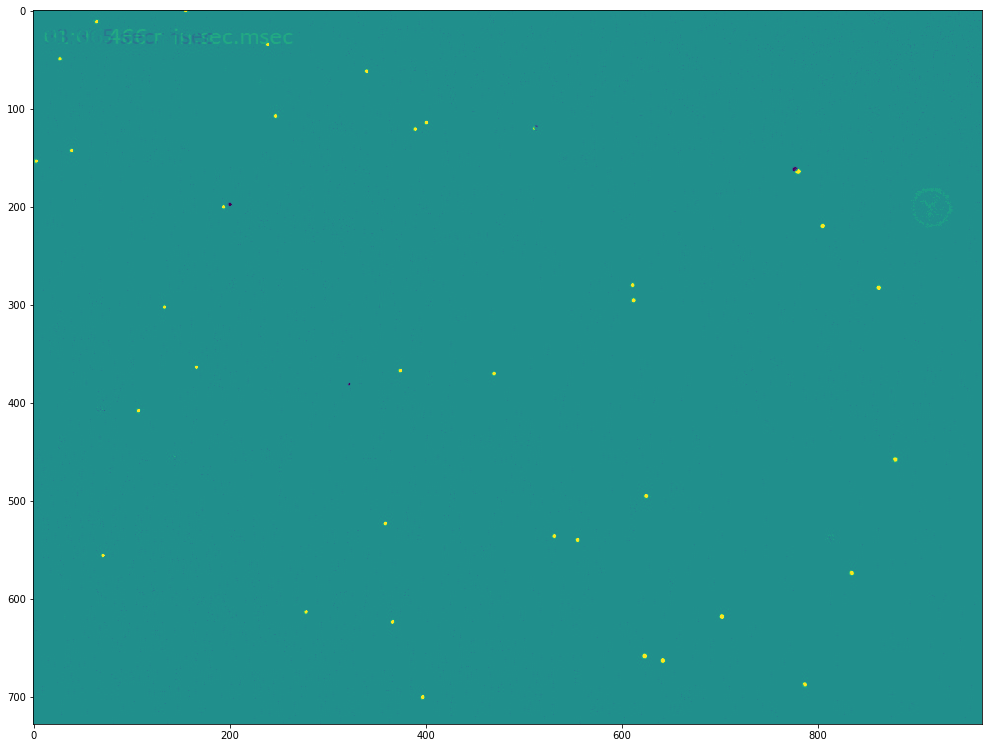

In [8]:
fig, ax = plt.subplots(figsize=(17, 17))
plt.imshow(im1-background)

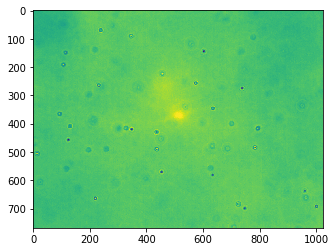

In [5]:
#plt.imshow(v[0])

Locate the particles in the image using tp.locate
The inputs are the image, the approximate size of each particle in pix (better to overestimate), the threshold contrast of the particle to keep (trial and error), and the maximum size of the particle. Invert should be true for a dark particle against a lighter background. 

In [17]:
f = tp.locate(im1-background,7,minmass=200,maxsize=21,invert=False,separation= 10)

You can find more information about the inputs of a function by typing its name with a question mark:

In [18]:
len(f) #how many particles were found in this frame

44

This is what the output looks like. It is a pandas dataframe:

In [19]:
f

,y,x,mass,size,ecc,signal,raw_mass,ep
15,11.134254,64.078453,942.718154,1.367136,0.144286,122.917947,2421.0,0.001694
32,20.593596,84.721675,211.460536,1.716337,0.077178,19.271034,756.0,0.005424
38,22.439623,30.154717,276.044542,1.552235,0.169105,31.250326,436.0,0.009402
47,24.132710,173.175701,278.648736,1.698267,0.257717,29.166970,318.0,0.012888
50,25.105263,213.178490,227.606538,1.726095,0.216086,20.312712,720.0,0.005695
52,25.842202,54.944954,283.857124,1.761984,0.379251,27.083615,397.5,0.010312
56,26.965517,159.247126,362.503776,1.745273,0.277879,31.771164,484.0,0.008470
68,29.809859,124.697183,221.877311,1.693678,0.265458,22.916905,464.0,0.008835
71,30.803653,92.744292,228.127376,1.315520,0.320199,35.417036,74.0,0.055213
72,30.482759,105.703065,271.877832,1.418947,0.230437,35.417036,302.0,0.013570


View the result and modify above parameters until particles are successfully found:

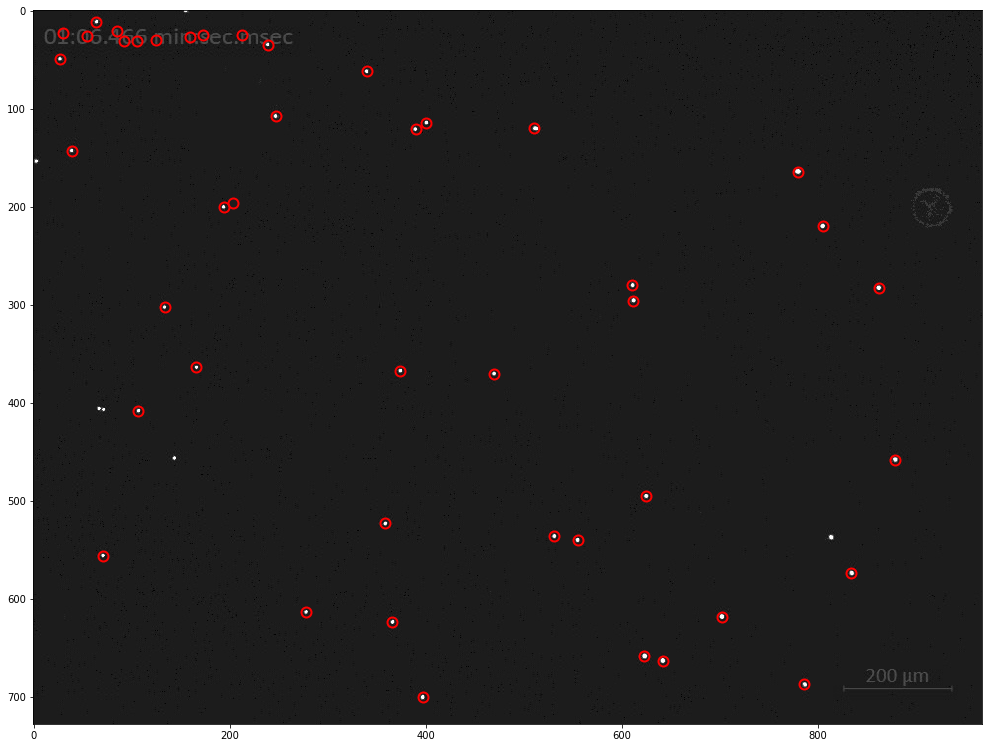

In [20]:
fig, ax = plt.subplots(figsize=(17, 17))
tp.annotate(f,im1, plot_style=dict(markersize=10))
#tp.annotate(f,v[0], plot_style=dict(markersize=10))

Paste settings into the batch function:

In [10]:
#f=tp.batch(v[:],15,minmass=700,maxsize=25,invert=True)

Frame 299: 28 features


use this one if you imported a video rather than an image sequence:

In [21]:
vid.set(1, 0)
suc,im1 = vid.read()
im1 = cv.cvtColor(im1,cv.COLOR_BGR2GRAY);
f = tp.locate(im1-background,7,minmass=200,maxsize=21,invert=False,separation= 10)
framedf = {'frame': np.ones(len(f.x))*0}
framedf = pd.DataFrame(data=framedf)
f['frame'] = framedf.frame
f['frame'] = np.ones(len(f.frame))*0
t1 = f
for i in np.array(list(range(1,totalNoFrames))):
    vid.set(1, i-1)
    suc,im1 = vid.read()
    im1 = cv.cvtColor(im1,cv.COLOR_BGR2GRAY);
    #f = tp.locate(im1-background,21,minmass=1000,maxsize=31,invert=True,separation= 15)
    f = tp.locate(im1-background,7,minmass=200,maxsize=21,invert=False,separation= 10)
    framedf = {'frame': np.ones(len(f.x))*i}
    framedf = pd.DataFrame(data=framedf)
    f['frame'] = framedf.frame
    f['frame'] = np.ones(len(f.frame))*i
    t1 = pd.concat([t1,f])

In [35]:
t1

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
28,6.986736,217.598039,223.330841,1.886332,0.136497,14.811446,761.0,0.008256,0.0
29,6.972090,484.799881,216.891082,1.824549,0.308453,19.190482,656.0,0.009614,0.0
61,10.570084,1145.949791,123.128192,1.381664,0.094822,15.584217,268.0,0.024494,0.0
66,11.882723,1747.701073,348.133370,1.657392,0.109441,28.334939,962.0,0.006500,0.0
116,18.807098,1483.113570,308.464455,1.504898,0.102434,31.039638,840.0,0.007463,0.0
...,...,...,...,...,...,...,...,...,...
9296,1411.872514,1259.977396,135.890872,1.922081,0.241181,8.477821,617.0,0.010767,374.0
9386,1425.744917,362.901571,265.884129,1.966329,0.213995,17.447110,819.0,0.008053,374.0
9408,1431.064138,565.497490,220.300483,1.872691,0.200662,15.481239,728.0,0.009084,374.0
9495,1445.216015,371.951117,263.918258,1.966787,0.240936,17.692844,856.0,0.007697,374.0


Link the trajectories of each particle using tp.link_df. The first input is just the coordinate data found above. The second input is the maximum distance a particle may have traveled between frames. The memory is the maximum number of frames between which a particle is not found before it is considered a different particle.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019CED7CDD08>,
      dtype=object)

<Figure size 432x288 with 0 Axes>

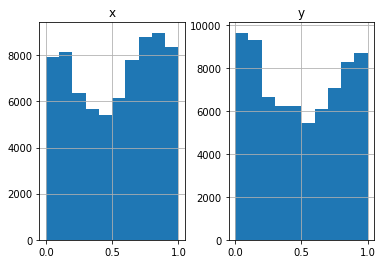

In [22]:
plt.figure()
tp.subpx_bias(t1)

In [23]:
#t = tp.link_df(f, 80, memory=5)
t = tp.link_df(t1, 3, memory=9)

Frame 1912: 44 trajectories present.


Eliminate particles that were tracked for only a short time and therefore do not have good statistics:

In [24]:
t1 = tp.filter_stubs(t, 100)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 502
After: 61


In [38]:
totalNoFrames

375

filter the data further if desired, otherwise set t2=t1 and move on to the next step

In [173]:
condition = lambda x: ((x['mass'].mean() > 5000) & (x['size'].mean() < 18) &
                       (x['ecc'].mean() < 0.9) & (x['mass'].mean() < 9000))
t2 = tp.filter(t1, condition)  # ecc is the eccentricity value

In [25]:
t2=t1

In [41]:
len(np.unique(t2['particle'])) #how many particles remain

203

The next few cells eliminate particles that are close to one another, so that particle-particle interactions do not come into play

If the particles are sufficiently far apart, we can skp this step and simply set t3=t2 and move on to viewing the image with the tracked particles

In [26]:
t3=t2

In [124]:
distance_threshold = 50;#set the minimum average distance between particles and run the next cell

In [125]:
empty_array = np.empty(int(len(np.unique(t1.particle))));
empty_array[:] = np.NAN;
avgpos = {'particle' : empty_array ,'x' : empty_array, 'y' : empty_array}
avgpos = pd.DataFrame(avgpos)
for i in range(int(len(np.unique(t1.particle)))):
    partnum = np.unique(t1.particle)[i];
    avg = np.mean(t1.loc[t1.particle==partnum]);
    avgpos.loc[i]=[partnum,avg.x,avg.y]
numparticles=len(np.unique(t1.particle));
Dist_Matrix = np.empty([numparticles,numparticles])
Dist_Matrix.fill(np.nan)
for p in range(0,numparticles):
    for q in range(0,p): #symmetry wrt p and q
        distSquared = (avgpos.loc[p].x-avgpos.loc[q].x)**2+(avgpos.loc[p].y-avgpos.loc[q].y)**2;
        Dist_Matrix[p,q] = distSquared;
        Dist_Matrix[q,p] = distSquared;
thresh_distSquared = distance_threshold**2;
zerosArray= np.zeros([numparticles,numparticles]);
onesArray= np.ones([numparticles,numparticles]);
thresh_distance_matrix =np.where(Dist_Matrix < thresh_distSquared,onesArray,zerosArray);
particles = np.unique(t1.particle);
close_particles=np.array([]);
for j in range(numparticles):
    if np.sum(thresh_distance_matrix[:,j])>0:
        close_particles=np.append(particles[j],close_particles)

C:\Users\driva\anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less


The number of particles that will be eliminated:

In [126]:
len(close_particles)

43

In [127]:
t3=t2;
for particle_drop in close_particles:
    t3 = t3[t3.particle != particle_drop]

In [128]:
len(np.unique(t3['particle'])) #how many particles remain

18

View the first frame with the original tracked particles:

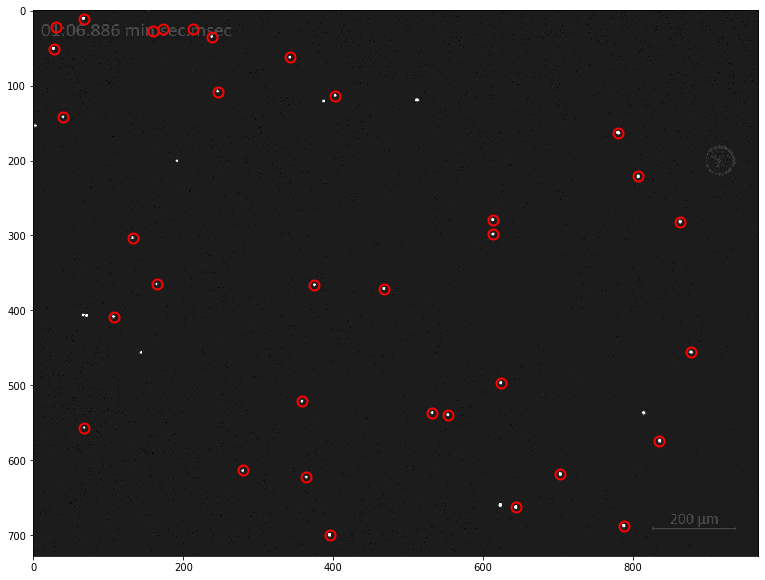

In [122]:
fig, ax = plt.subplots(figsize=(13, 13))
#tp.annotate(t1[t1['frame'] == 0], v[0], plot_style=dict(markersize=10))
tp.annotate(t1[t1['frame'] == totalNoFrames-1], im1, plot_style=dict(markersize=10))

View the first frame with the tracked particles that remain after filtering:

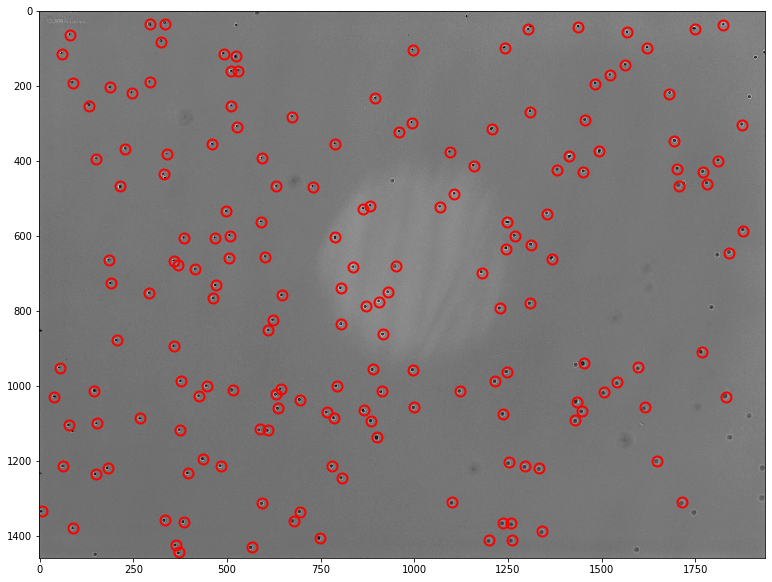

In [46]:
fig, ax = plt.subplots(figsize=(13, 13))
#tp.annotate(t1[t1['frame'] == 0], v[0], plot_style=dict(markersize=10))
tp.annotate(t3[t3['frame'] == totalNoFrames-1], im1, plot_style=dict(markersize=10))

View particle trajectories:

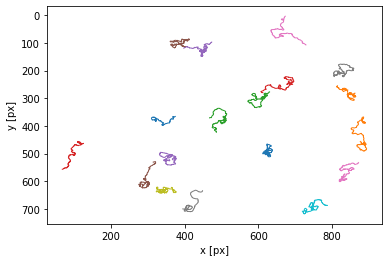

In [129]:
plt.figure()
tp.plot_traj(t3)

In [130]:
t3.to_csv('trajs.csv')#save trajectories to csv in current directory

### Subtract Drift

In [131]:
d = tp.compute_drift(t3)#ignore errors

Plot the drift:

<Figure size 432x288 with 0 Axes>

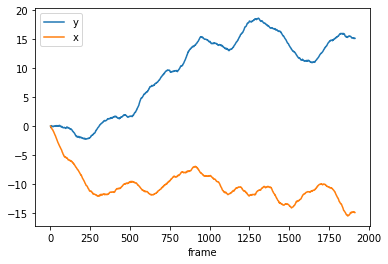

In [132]:
plt.figure()
d.plot()

In [133]:
d.to_csv('drift.csv')#save drift to csv

In [134]:
tm = tp.subtract_drift(t3, d)#subtract drift from trajectories

In [135]:
tm.to_csv('trajectories_drift_subtracted.csv')#save trajectories to csv

View the new trajectories:

<Figure size 432x288 with 0 Axes>

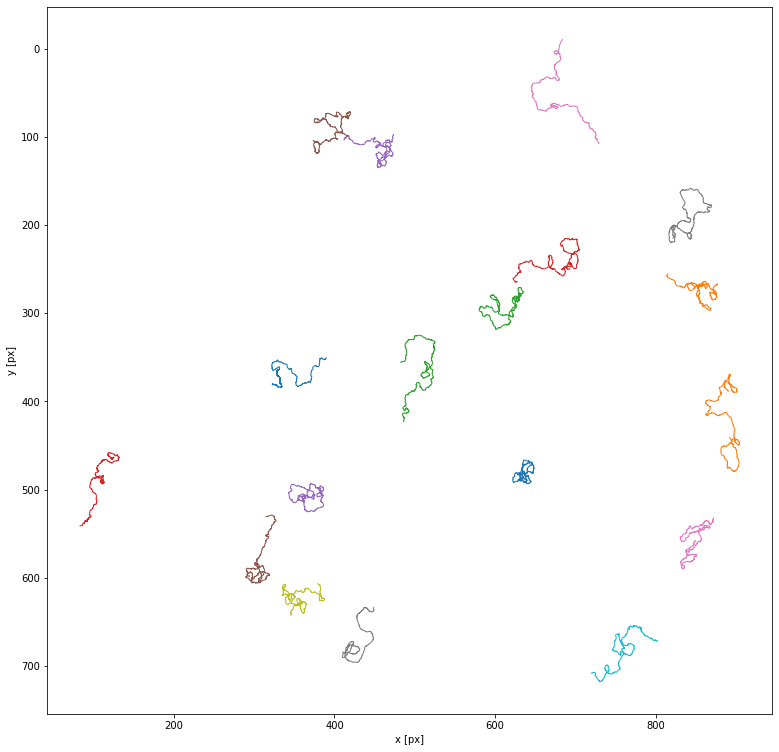

In [136]:
plt.figure()
fig, ax = plt.subplots(figsize=(13, 13))
tp.plot_traj(tm)

### Find the individual particle mean-squared-displacements:

Inputs in tp.imsd function are the trajectories with the drift subtracted, the length of each pixel in microns, and the frame rate:

In [137]:
im = tp.imsd(tm, 0.9,2.84 )  # microns per pixel = 0.154 fps = 0.5

Plot individual MSDs on log-log scale:

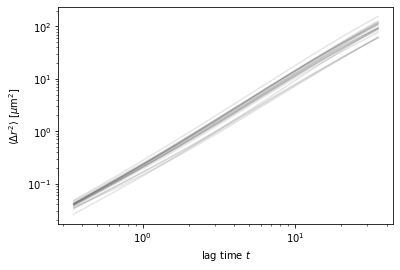

In [138]:
fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set_xscale('log')
ax.set_yscale('log')

[Text(0, 0.5, '$\\langle \\Delta r^2 \\rangle$ [$\\mu$m$^2$]'),
 Text(0.5, 0, 'lag time $t$')]

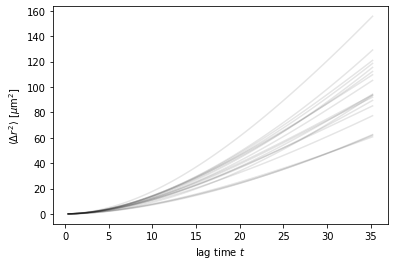

In [139]:
fig, ax = plt.subplots()
ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')


### Find the ensemble averaged MSD

In [140]:
em = tp.emsd(tm,  0.9,2.84 )#find the ensemble average MSD

Plot the average MSD:

[(0.02, 120)]

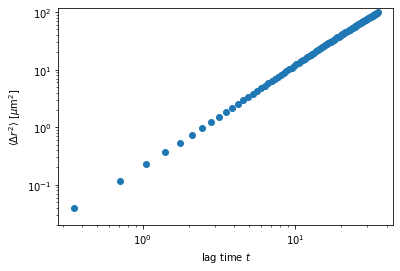

In [141]:
fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set(ylim=(2e-2, 120))

[(0.02, 120)]

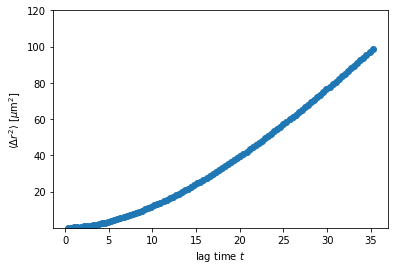

In [142]:
fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set(ylim=(2e-2, 120))

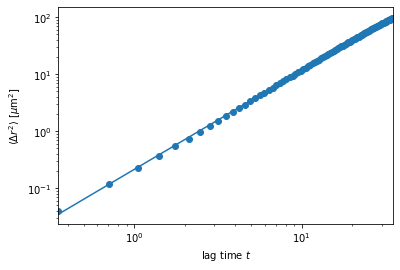

,n,A
msd,1.73499,0.213933


In [143]:
plt.figure()
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.xlabel('lag time $t$');
tp.utils.fit_powerlaw(em)

In [45]:
em.to_csv('msd_avg.csv')#save ensemble averaged MSD

### Find the histogram of particle displacements at different lag times (aka, the Van Hove Correlation plot):

In [144]:
pos = t3.set_index(['frame', 'particle'])['x'].unstack() # particles as columns

frame lag of 2:

In [145]:
vh=tp.vanhove(pos,1,ensemble=True,bins=20)

In [147]:
yvals = [];
for i in range(len(vh)):
    yvals = np.append(vh.iloc[i],yvals)

In [148]:
xvals = [];
for i in range(len(vh)):
    xvals = np.append(vh.index[i],xvals)

In [149]:
yvals

array([1.86163758e-03, 4.49784934e-03, 2.32789960e-02, 8.45562248e-02,
       2.47843204e-01, 5.79884404e-01, 1.15935037e+00, 1.83823715e+00,
       2.56179516e+00, 2.45991825e+00, 1.86404329e+00, 1.13407597e+00,
       5.18171182e-01, 2.26404984e-01, 7.70537544e-02, 2.07195539e-02,
       4.12735672e-03, 1.11639713e-03, 0.00000000e+00, 3.72132376e-04])

In [150]:
xvals

array([ 0.61390302,  0.53582259,  0.45774217,  0.37966175,  0.30158133,
        0.22350091,  0.14542049,  0.06734006, -0.01074036, -0.08882078,
       -0.1669012 , -0.24498162, -0.32306204, -0.40114247, -0.47922289,
       -0.55730331, -0.63538373, -0.71346415, -0.79154458, -0.869625  ])

Define a gaussian function with coefficient A, mean u, and variance v:

In [151]:
def gaussian(x,A,v,u):
    return A*np.exp(-((x-u)**2)/(2*v))

In [152]:
init_vals = [1, 2, 0]  # for [amp, sigma squared, mean]
best_vals, covar = curve_fit(gaussian, xvals, yvals, p0=init_vals)

In [153]:
best_vals

array([ 2.54537768,  0.0240447 , -0.04798642])

[-1, 1, -0.02, 3]

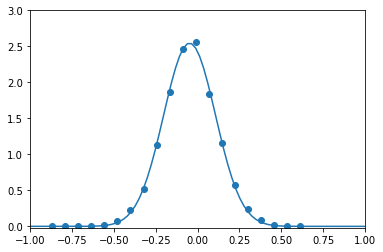

In [154]:
plt.scatter(xvals, yvals)
plt.plot(np.linspace(-12,12,1000),gaussian(np.linspace(-12,12,1000),best_vals[0],best_vals[1],best_vals[2]))
plt.axis([-1, 1, -0.02, 3])

### Fit the MSD

In [155]:
from scipy import stats

Let's fit the last 15 points:

In [156]:
len(em)

100

In [157]:
timelags = em.index[85:100]

In [92]:
msd_vals = [];
for i in range(15):
    msd_vals = np.append(em.iloc[i],msd_vals)
msd_vals = np.flip(msd_vals)

In [93]:
slope, intercept, r_value, p_value, std_err = stats.linregress(timelags,msd_vals)

In [94]:
slope

58.69412429092399

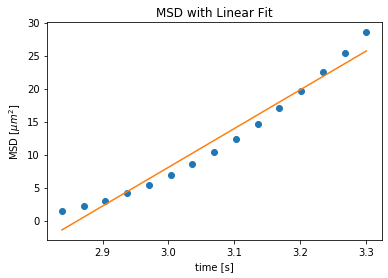

In [95]:
line = slope*timelags+intercept

plt.plot(timelags,msd_vals,'o', timelags, line)
plt.title('MSD with Linear Fit')
plt.ylabel('MSD [$\mu m^2$]')
plt.xlabel('time [s]')
ax = plt.gca()
fig = plt.gcf()

find the diffusion constant (in microns squared per second):

In [96]:
diff_const = slope/4

In [97]:
diff_const

14.673531072730997

In [99]:
timelags = em.index[0:10]

In [100]:
msd_vals = [];
for i in range(10):
    msd_vals = np.append(em.iloc[i],msd_vals)
msd_vals = np.flip(msd_vals)

In [101]:
slope, intercept, r_value, p_value, std_err = stats.linregress(timelags,msd_vals)

In [102]:
slope

44.315585540980386

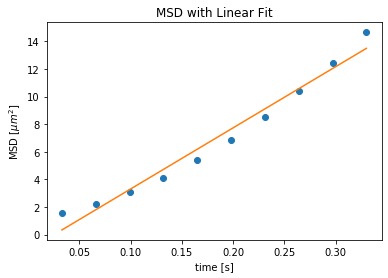

In [103]:
line = slope*timelags+intercept

plt.plot(timelags,msd_vals,'o', timelags, line)
plt.title('MSD with Linear Fit')
plt.ylabel('MSD [$\mu m^2$]')
plt.xlabel('time [s]')
ax = plt.gca()
fig = plt.gcf()

find the diffusion constant (in microns squared per second):

In [104]:
diff_const = slope/4

In [105]:
diff_const

11.078896385245097

And this is the effective temp (times room temp) we get from D = kT/(6$\pi$a$\eta$):

In [109]:
0.001/((1.38*10**(-23))*293/(diff_const*10**(-12)*6*np.pi*0.5*10**(-6)))

25.823845892393905

26 times room temp

## Velocity

In [158]:
particle_nums = np.unique(tm.particle)

In [159]:
particle_data1 = tm[tm.particle == particle_nums[0]]

In [160]:
particle_data1_smoothed=particle_data1.rolling(3,center=True,min_periods=1).mean()

In [161]:
xsmoothed = UnivariateSpline(particle_data1.frame, np.array(particle_data1_smoothed.x),s = 0.2)
ysmoothed = UnivariateSpline(particle_data1.frame, np.array(particle_data1_smoothed.y),s=0.2)# s essentially sets the amount of smoothing of the spline fit

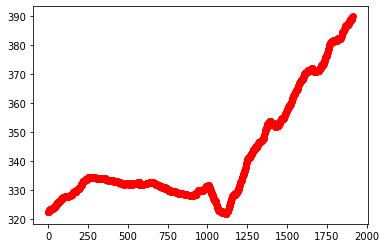

In [162]:
plt.plot(particle_data1.frame,xsmoothed(particle_data1.frame))
plt.plot(particle_data1.frame,particle_data1.x,'or')

In [163]:
vx = xsmoothed.derivative()
vy = ysmoothed.derivative()#find the velocity

Text(0, 0.5, 'x-velocity')

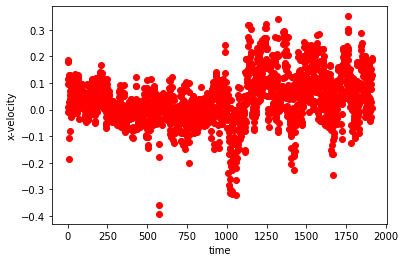

In [164]:
plt.plot(particle_data1.frame,vx(particle_data1.frame),'or')
plt.xlabel('time')
plt.ylabel('x-velocity')

In [165]:
speeds = np.ones((len(particle_nums),2))*np.nan
for i in range(len(particle_nums)):
        particle_data1 = t3[t3.particle == particle_nums[i]]
        if len(particle_data1.x) > 10:
            #set missing data to nan (let's ignore missing data for now; so this is commented out):
            #particle_data1.set_index("frame")
            #new_index = pd.Index(np.arange(np.min(particle_data1.frame),np.max(particle_data1.frame),1), name="frame")
            #particle_data1=particle_data1.set_index("frame").reindex(new_index)
            #smooth the data:
            particle_data1_smoothed=particle_data1.rolling(3,center=True,min_periods=1).mean()
            #run spline interpolation:
            xsmoothed = UnivariateSpline(particle_data1.frame, np.array(particle_data1_smoothed.x),s=0.2)
            ysmoothed = UnivariateSpline(particle_data1.frame, np.array(particle_data1_smoothed.y),s=0.2)
            #xsmoothed.set_smoothing_factor(3)
            #ysmoothed.set_smoothing_factor(3)#smooth the fit
            vx = xsmoothed.derivative()
            vy = ysmoothed.derivative()#find the velocity
            speed = np.sqrt(vy(particle_data1.frame)**2+vx(particle_data1.frame)**2)#find the speed
            speeds[i,0] = np.mean(speed[2:-2])#find the average speed, ignore edges because the fits probably aren't great there
            speeds[i,1] = particle_nums[i]

In [166]:
speeds

array([[ 0.11918691,  1.        ],
       [ 0.19252427,  3.        ],
       [ 0.1733327 ,  5.        ],
       [ 0.13761769,  6.        ],
       [ 0.17525929,  9.        ],
       [ 0.16761933, 10.        ],
       [ 0.1648139 , 11.        ],
       [ 0.14835083, 16.        ],
       [ 0.17126177, 17.        ],
       [ 0.16309151, 18.        ],
       [ 0.15368495, 22.        ],
       [ 0.16232212, 23.        ],
       [ 0.1829908 , 24.        ],
       [ 0.17877126, 35.        ],
       [ 0.17856458, 36.        ],
       [ 0.15528774, 37.        ],
       [ 0.17575299, 38.        ],
       [ 0.17075247, 43.        ]])

avg speed px/frame

In [167]:
np.mean(speeds[:,0])

0.16506583873589353

avg speed um/s

In [168]:
np.mean(speeds[:,0])*100*2.84/(111)

0.4223306144233672